### Importación Bibliotecas

In [1]:
!pip install imutils --quiet
!pip install livelossplot --quiet

In [28]:
import keras
import tensorflow as tf
import numpy as np
import sys
print(f'{sys.version}')
print(f'keras {keras.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'numpy {np.__version__}')

import pandas as pd
import os
from imutils import paths
import cv2
import matplotlib.pyplot as plt
import boto3
from PIL import Image

from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
from livelossplot.inputs.keras import PlotLossesCallback
from sklearn.metrics import accuracy_score

3.6.13 | packaged by conda-forge | (default, Feb 19 2021, 05:36:01) 
[GCC 9.3.0]
keras 2.3.0
tensorflow 2.1.3
numpy 1.18.5


In [29]:
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


In [30]:
import os
class_subset = sorted(os.listdir(f'./img/train'))
print(f'clasess {class_subset}')

clasess ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [31]:
train_data = f'./img/train'
test_data = f'./img/test_1000'
ac_labels = {"c0": "safe driving",
             "c1": "texting - right",
             "c2": "talking on the phone - right",
             "c3": "texting - left",
             "c4": "talking on the phone - left",
             "c5": "operating the radio",
             "c6": "drinking",
             "c7": "reaching behind",
             "c8": "hair and makeup",
             "c9": "talking to passenger"}

In [54]:
print(f'train_data {train_data}')
print(f'test_data {test_data}')
print(f'class_subset {class_subset}')
n_fotos = 0
for category in class_subset:
    n_fotos += len(os.listdir(f'./img/test_1000/{category}'))
print(n_fotos)

train_data ./img/train
test_data ./img/test_1000
class_subset ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
1002


### Data Augmentation

In [7]:
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)           # VGG16 preprocessing

### Preparación Conjunto de Imágenes para Entrenamiento

In [8]:
testgen = test_generator.flow_from_directory(test_data,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 1002 images belonging to 10 classes.


In [33]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0, n_model=1):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    if n_model == 4:
        conv_base = VGG19(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    else:
        conv_base = VGG16(include_top=False,
                         weights='imagenet', 
                         input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    
    if n_model == 1 or n_model == 2:
        top_model = Dense(4096, activation='relu')(top_model)
        top_model = Dense(1072, activation='relu')(top_model)

    if n_model == 3 or n_model == 4:
        top_model = Dense(4096, activation='relu')(top_model)
        top_model = Dense(1024, activation='relu')(top_model)
        top_model = Dense(256, activation='relu')(top_model)
        top_model = Dense(64, activation='relu')(top_model)
        
    if n_model == 5:    
        top_model = Dense(4096, activation='relu')(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dense(1024, activation='relu')(top_model)
        top_model = Dense(512, activation='relu')(top_model)
        top_model = Dense(256, activation='relu')(top_model)
        top_model = Dense(128, activation='relu')(top_model)
        top_model = Dense(64, activation='relu')(top_model)
        top_model = Dense(32, activation='relu')(top_model)
    
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [34]:
input_shape = (224, 224, 3)
optim = Adam(lr=0.0001)
n_classes=len(class_subset)

### Comprobación del Accuracy del Modelo

In [38]:
true_classes = testgen.classes
class_indices = testgen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
model_list = []
for i in [1, 2, 3, 4, 5]:
    model = create_model(input_shape, n_classes, optim, fine_tune=2, n_model=i)
    model.load_weights(f'./model/model{i}.hdf5')
    model_pred = model.predict(testgen)
    model_pred_classes = np.argmax(model_pred, axis=1)
    model_list.append(model_pred_classes)
    from sklearn.metrics import accuracy_score
    model_acc_ft = accuracy_score(true_classes, model_pred_classes)
    print("VGG16 Model {} Accuracy with Fine-Tuning: {:.2f}%".format(i, model_acc_ft * 100))

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Ran

In [41]:
VGG16 Model 1 Accuracy with Fine-Tuning: 80.44%
VGG16 Model 2 Accuracy with Fine-Tuning: 83.73%
VGG16 Model 3 Accuracy with Fine-Tuning: 88.12%
VGG19 Model 4 Accuracy with Fine-Tuning: 84.53%
VGG16 Model 5 Accuracy with Fine-Tuning: 86.63%


[array([7, 8, 0, ..., 8, 3, 0]),
 array([8, 0, 9, ..., 8, 0, 9]),
 array([0, 1, 0, ..., 8, 0, 9]),
 array([7, 3, 5, ..., 8, 0, 9]),
 array([8, 1, 9, ..., 8, 0, 8])]

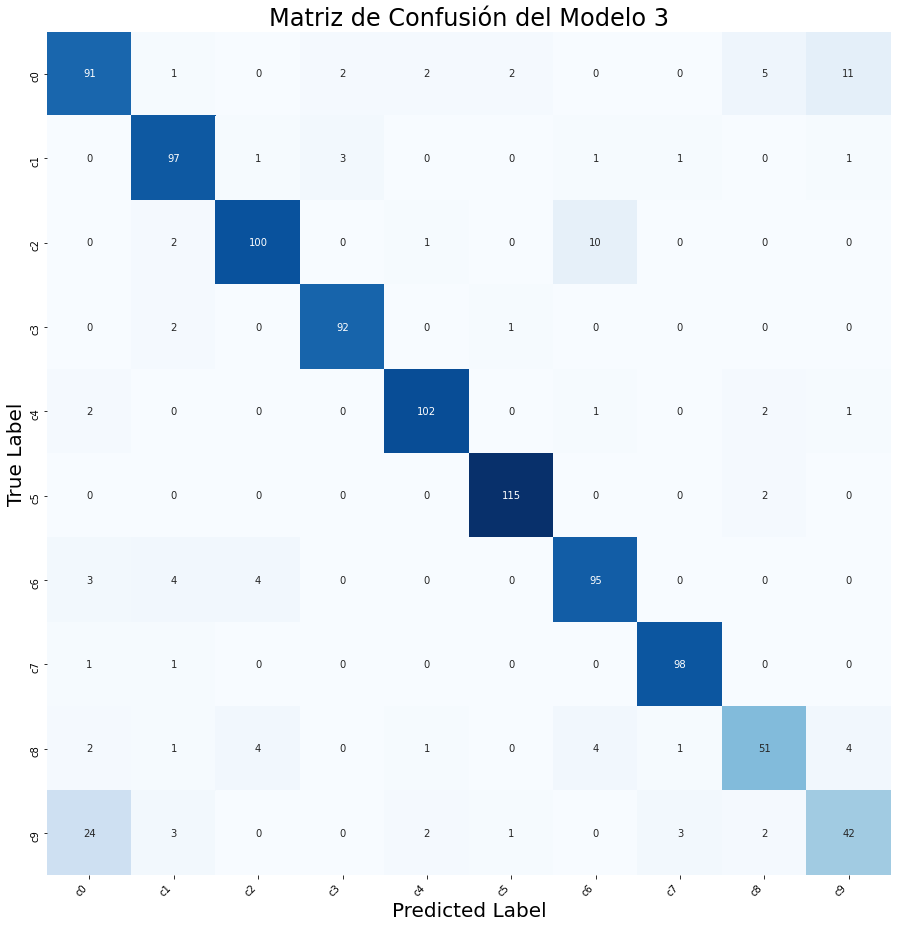

In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=24)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=20)
    ax.set_xlabel('Predicted Label', fontsize=20)

# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

# for i, _model in enumerate(model_list):
#     plot_heatmap(true_classes, _model, class_names, ax1, title=f"model{i+1}")    

plot_heatmap(true_classes, model_list[2], class_names, ax1, title=f"Matriz de Confusión del Modelo 3")    

# fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

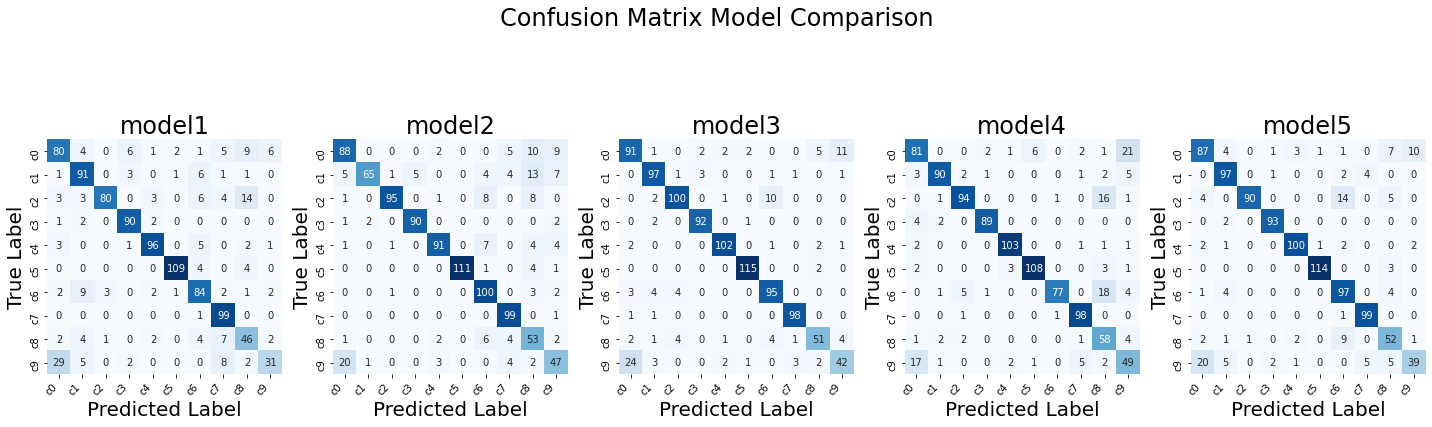

In [58]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=24)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=20)
    ax.set_xlabel('Predicted Label', fontsize=20)

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i, _model in enumerate(model_list):
    plot_heatmap(true_classes, _model, class_names, axes[i], title=f"model{i+1}")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()